In [1]:
from joblib import load
import numpy as np
import pandas as pd

# fetch training data (thank you keegan)
df = load('../DL_data/results_dataframe/results_dataframe.pkl')
print(type(df))
print(f'DF {df.shape}')
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
DF (10980480, 5)
Index(['n', 'k', 'm', 'result', 'P'], dtype='object')


In [ ]:
# df1 = df[df['n']==9 & df['k']==4 & df['m']==2]
# df2 = df[df['n']==9 & df['k']==4 & df['m']==3]
# df3 = df[df['n']==9 & df['k']==4 & df['m']==4]
# df4 = df[df['n']==9 & df['k']==4 & df['m']==5]

# df5 = df[df['n']==9 & df['k']==5 & df['m']==2]
# df6 = df[df['n']==9 & df['k']==5 & df['m']==3]
# df7 = df[df['n']==9 & df['k']==5 & df['m']==4]

# df8 = df[df['n']==9 & df['k']==6 & df['m']==2]
# df9 = df[df['n']==9 & df['k']==6 & df['m']==3]

# df10 = df[df['n']==10 & df['k']==4 & df['m']==2]
# df11 = df[df['n']==10 & df['k']==4 & df['m']==3]
# df12 = df[df['n']==10 & df['k']==4 & df['m']==4]
# df13 = df[df['n']==10 & df['k']==4 & df['m']==5]
# df14 = df[df['n']==10 & df['k']==4 & df['m']==6]

# df15 = df[df['n']==10 & df['k']==5 & df['m']==2]
# df16 = df[df['n']==10 & df['k']==5 & df['m']==3]
# df17 = df[df['n']==10 & df['k']==5 & df['m']==4]
# df18 = df[df['n']==10 & df['k']==5 & df['m']==5]

# df19 = df[df['n']==10 & df['k']==6 & df['m']==2]
# df20 = df[df['n']==10 & df['k']==6 & df['m']==3]
# df21 = df[df['n']==10 & df['k']==6 & df['m']==4]

Using device: cpu
n:9, k:4, m:2
num_train_samples: 297078 num_val_samples: 114261 num_test_samples: 45705
Epoch 1/10 — train: 0.3699, val: 0.2223
Best model saved at epoch 1 with val loss: 0.2223
Epoch 2/10 — train: 0.2231, val: 0.2280
Epoch 3/10 — train: 0.2205, val: 0.2180
Best model saved at epoch 3 with val loss: 0.2180
Epoch 4/10 — train: 0.2147, val: 0.2163
Best model saved at epoch 4 with val loss: 0.2163
Epoch 5/10 — train: 0.2071, val: 0.2034
Best model saved at epoch 5 with val loss: 0.2034
Epoch 6/10 — train: 0.2018, val: 0.2022
Best model saved at epoch 6 with val loss: 0.2022
Epoch 7/10 — train: 0.2014, val: 0.2009
Best model saved at epoch 7 with val loss: 0.2009
Epoch 8/10 — train: 0.2015, val: 0.2054
Epoch 9/10 — train: 0.2012, val: 0.2002
Best model saved at epoch 9 with val loss: 0.2002
Epoch 10/10 — train: 0.2012, val: 0.2002


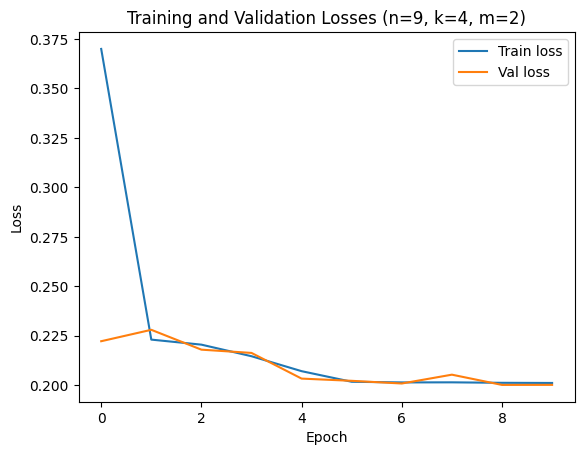

Test Ratio Loss: 0.203407


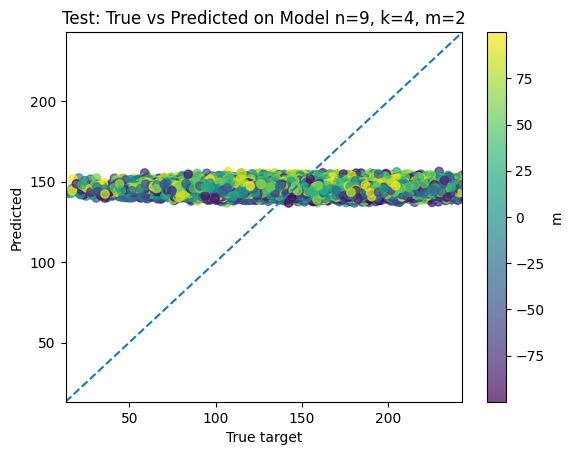

n:9, k:4, m:3
num_train_samples: 298112 num_val_samples: 114658 num_test_samples: 45865


KeyboardInterrupt: 

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

class MyDataset(Dataset):
    def __init__(self, df):
        # self.ms = df['m'].astype(int).values
        # self.n_rows = df['k'].astype(int).values
        # self.n_cols = df['n'].astype(int).values - df['k'].astype(int).values
        self.X = df['P'].apply(lambda s: torch.tensor(s, dtype=torch.float32))
        self.y = torch.tensor(df['result'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X.iloc[idx], self.y[idx]

class DenseNet(nn.Module):
    def __init__(self, n,k,m):
        super().__init__()
        # consider ELU GELU
        self.net = nn.Sequential(
            nn.Linear(INPUT_DIM, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 32),
            nn.LeakyReLU(0.01),
            nn.Linear(32, 1)
        )
        self.n = n
        self.k = k
        self.m = m

    def forward(self, x):
        return self.net(x)
    
    def __str__(self):
        return f'DenseNet(n={self.n}, k={self.k}, m={self.m})'

def ratio_loss(preds, targets, eps=1e-6):
    preds = torch.clamp(preds, min=eps)
    targets = torch.clamp(targets, min=eps)
    return torch.mean((torch.log2(targets) - torch.log2(preds))**2)
criterion = ratio_loss

def train(model, train_loader, val_loader):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_state = None
    for epoch in range(EPOCHS):
        model.train()
        epoch_train_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(X)
            loss = criterion(preds, y)
            loss.backward(); optimizer.step()
            epoch_train_loss += loss.item()

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                epoch_val_loss += criterion(model(X), y).item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_val_loss = epoch_val_loss / len(val_loader)
        train_losses.append(epoch_train_loss/len(train_loader))
        val_losses.append(epoch_val_loss/len(val_loader))
        print(f"Epoch {epoch+1}/{EPOCHS} — train: {avg_train_loss:.4f}, val: {avg_val_loss:.4f}")

        # Save model if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            torch.save(best_model_state, f"model{model.n}_{model.k}_{model.m}.pt")
            print(f"Best model saved at epoch {epoch+1} with val loss: {best_val_loss:.4f}")

    # Plot losses
    plt.figure()
    plt.plot(train_losses, label="Train loss")
    plt.plot(val_losses, label="Val loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.title(f"Training and Validation Losses (n={model.n}, k={model.k}, m={model.m})")
    plt.show()

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model

def test_and_plot(model, test_loader):
    model.eval()

    all_preds, all_targets, all_features = [], [], []
    total_loss = 0
    criterion = ratio_loss

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).reshape(-1)
            total_loss += criterion(preds, y).item() * X.size(0)

            all_preds.append(preds.cpu())
            all_targets.append(y.cpu())
            all_features.append(X[:, 0].cpu())    # column 0 = “m”

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    loss = total_loss / len(test_loader.dataset)
    print(f"Test Ratio Loss: {loss:.6f}")

    # 95% bounds
    combined = np.concatenate([all_targets, all_preds])
    low, high = np.percentile(combined, [0, 99])

    plt.figure()
    sc = plt.scatter(all_targets, all_preds)
    plt.plot([low, high], [low, high], linestyle='--')
    plt.xlim(low, high); plt.ylim(low, high)
    plt.xlabel("True target"); plt.ylabel("Predicted")
    plt.title(f"Test: True vs Predicted on Model n={model.n}, k={model.k}, m={model.m}")
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
BATCH_SIZE = 64
EPOCHS = 15
for n in [9,10]:
    for k in [4,5,6]:
        for m in list(range(n-k+1))[2:]:
            data = df[(df['n'] == n) & (df['k'] == k) & (df['m'] == m)]
            num_train_samples = int(0.65 * len(data))
            num_val_samples = int(0.25 * len(data))
            num_test_samples = len(data) - num_train_samples - num_val_samples
            print(f'n:{n}, k:{k}, m:{m}')
            print("num_train_samples:", num_train_samples,"num_val_samples:", num_val_samples,"num_test_samples:", num_test_samples)
            dataset = MyDataset(data)
            train_data, val_data, test_data = random_split(dataset, [num_train_samples, num_val_samples, num_test_samples])
            # loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
            train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
            val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
            test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

            INPUT_DIM = k*(n-k)
            model = DenseNet(n,k,m).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            model = train(model, train_loader, val_loader)
            test_and_plot(model, test_loader)


In [3]:
print(data)

          n  k  m      result  \
1         9  4  2  140.163560   
9         9  4  2  162.300346   
15        9  4  2  217.263508   
16        9  4  2  146.251829   
36        9  4  2  125.830965   
...      .. .. ..         ...   
10980328  9  4  2  172.161426   
10980358  9  4  2  127.834937   
10980397  9  4  2  155.608418   
10980398  9  4  2  136.790719   
10980452  9  4  2  108.370651   

                                                          P  
1         [6.5178894459618135, -6.281201889271188, 99.66...  
9         [-88.48172895982646, 1.92925363611036, -53.250...  
15        [-62.70454405366304, 92.07945357330013, 37.450...  
16        [-89.46558729229577, 59.446747639708974, -6.71...  
36        [-34.137527580233765, -13.847638465166739, -67...  
...                                                     ...  
10980328  [-47.32410172415644, 58.124469863992374, -28.3...  
10980358  [-73.85032067717555, 41.333077515727865, -93.6...  
10980397  [11.060485038910684, -42.8105281718